This code is useful in data loading, visualization and exploration. You are free to modify the code. The code has dependecy on Pytorch Lightning data module. However, you may use Pytorch as well.

**Introduction to Dataset**

The data has a total of 10 classes with 40 samples each. Make sure while working with the data, **esc10=True**. In the assignment, you are required to perform 4-fold validation. This dataset has been already divided into 5-folds. The column 'fold' in the metafile denotes the sample in a particular fold. Moreover, first folds is considered for test, rest for 4-fold validation.

In [2]:
# DL Assignment 2
# Authors: Kopal Rastogi, Ishan Mishra
# Keywords: None
# Assumptions: None

In [3]:
# Installing the requirements
print('Installing Requirements... ',end='')
# !pip install lightning
print('Done')

Installing Requirements... Done


In [4]:
# Extract data
# with zipfile.ZipFile("/content/master.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/")

In [5]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
print('Done')

Importing Libraries... Done


In [6]:
# Download data
print('Downlading data... ', end='')
# Your code here
print('Done')

Downlading data... Done


In [7]:
# # Extract data
# with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/")

In [8]:
# Loading dataset
path = Path('./data')
df = pd.read_csv('./data/meta/esc50.csv')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


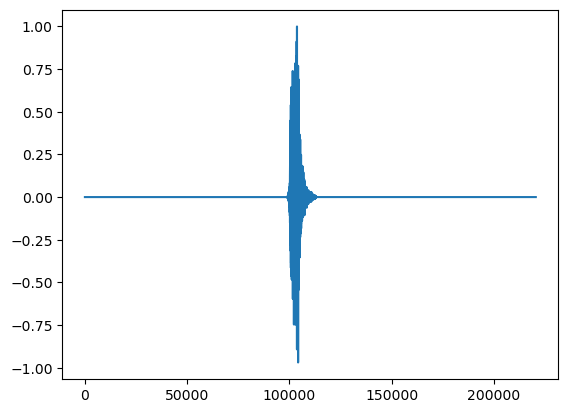

In [9]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[0])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [11]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        # examples = torch.cat(examples)
    
        examples = torch.stack(examples)
        # examples = examples.reshape(examples.size(0),-1,examples.size(-1))
        examples = examples.reshape(examples.size(0),1,-1)
        labels = torch.flatten(torch.tensor(labels))

        return examples, labels


In [12]:
# Data Setup
test_samp = 1 #""" Do not change this!! """
valid_samp = 2 # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
batch_size = 32 # Free to change
num_workers = 0 # Free to change
custom_data_module = CustomDataModule(batch_size=batch_size,
                                      num_workers=num_workers,
                                      data_directory=path,
                                      data_frame=df,
                                      validation_fold=valid_samp,
                                      testing_fold=test_samp,  # set to 0 for no test set
                                      esc_10_flag=True,
                                      file_column='filename',
                                      label_column='category',
                                      sampling_rate=44100,
                                      new_sampling_rate=16000,  # new sample rate for input
                                      sample_length_seconds=1  # new length of input in seconds
                                      )

custom_data_module.setup()


100%|██████████| 80/80 [00:00<00:00, 7554.92it/s]


100%|██████████| 80/80 [00:00<00:00, 9420.64it/s]


In [13]:
# Data Exploration
print('Class Label: ', custom_data_module.training_dataset[5][1])  # this prints the class label
print('Shape of data sample tensor: ', custom_data_module.training_dataset[5][0].shape)  # this prints the shape of the sample (Frames, Channel, Features)


Class Label:  0
Shape of data sample tensor:  torch.Size([9, 1, 16000])


In [14]:
# Dataloader(s)
x = next(iter(custom_data_module.train_dataloader()))
y = next(iter(custom_data_module.val_dataloader()))
z = next(iter(custom_data_module.test_dataloader()))
print('Train Dataloader:')
print(torch.tensor(x[0]).shape, len(x[1]))
print('Validation Dataloader:')
print(torch.tensor(y[0]).shape, len(y[1]))
print('Test Dataloader:')
print(torch.tensor(z[0]).shape, len(z[1]))


Train Dataloader:
torch.Size([32, 1, 144000]) 32
Validation Dataloader:
torch.Size([32, 1, 144000]) 32
Test Dataloader:
torch.Size([32, 1, 144000]) 32


C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_11152\3141816698.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(x[0]).shape, len(x[1]))
C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_11152\3141816698.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(y[0]).shape, len(y[1]))
C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_11152\3141816698.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(z[0]).shape, len(z[1]))


In [15]:
train_loader = custom_data_module.train_dataloader()
valid_loader = custom_data_module.val_dataloader()
test_loader = custom_data_module.test_dataloader()

In [70]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class model(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=11,stride=1,padding='valid')
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=9, stride=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        # self.conv5 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, stride=2)
        # self.conv6 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        # self.conv7 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=8192, out_features=1024)
        # self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc = nn.Linear(in_features=1024, out_features=n_classes)

        self.bn1 = nn.BatchNorm1d(32,affine=False)
        self.bn2 = nn.BatchNorm1d(64,affine=False)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        
        # y = x.clone()
        x = F.dropout1d(x,0.1)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool1d(x,kernel_size=16,stride=1)
        x = self.bn1(x)
        x = self.conv3(x)
        # x = x + y
        x = F.relu(x)
        x = F.max_pool1d(x,kernel_size=4,stride=1)
        x = self.conv4(x)
        x = F.adaptive_avg_pool1d(x,128)
        x = self.bn2(x)
        x = F.dropout1d(x,0.1)
        # x = F.relu(x)
        # x = F.max_pool1d(x,kernel_size=2,stride=1)
        # x = self.conv5(x)
        # x = F.relu(x)
        # x = F.max_pool1d(x,kernel_size=2,stride=1)
        # x = self.conv6(x)
        # x = F.relu(x)
        # x = F.max_pool1d(x,kernel_size=2,stride=1)
        # x = self.conv7(x)

        # x = F.avg_pool1d(x,kernel_size=2,stride=1)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x


def train(model, train_loader,valid_loader, optimizer, criterion, device,epochs = 10):

    history = {'train':{'loss':[],'accuracy':[]}, 'valid':{'loss':[],'accuracy':[]}}
    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = 0
        total = 0
        evaluation_train = {'accuracy':0, 'loss':0}
        for idx, data in enumerate(tqdm(train_loader)):
            input, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()


            Loss_epoch += loss.item()*len(labels)
            correct += accuracy(output, labels)*len(labels)
            total += len(labels)
        # Loss_history.append(Loss_epoch/n)
        evaluation_train['accuracy'] = correct/total
        evaluation_train['loss'] =  Loss_epoch/total
        # evaluation_train = evaluate(model, train_loader,criterion, device)
        evaluation_valid,_ = evaluate(model, valid_loader,criterion, device)
        print(f'train: {evaluation_train}, valid: {evaluation_valid}')
        history['train']['accuracy'].append(evaluation_train['accuracy'])
        history['train']['loss'].append(evaluation_train['loss'])



        history['valid']['loss'].append(evaluation_valid['loss'])
        history['valid']['accuracy'].append(evaluation_valid['accuracy'])
    return history


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()

def evaluate(model,data_loader, criterion, device,return_preds = False):
    model.eval()
    Accuracy_history = []
    Loss_history = []
    PREDS = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            output = model(input)
            loss = criterion(output, target)
            Accuracy_history.append(accuracy(output, target))
            Loss_history.append(loss.item())
            if return_preds:
                # PREDS.extend(torch.max(output, dim=1)[1].tolist())
                PREDS.extend(output.tolist())
    return {'accuracy': torch.mean(torch.Tensor(Accuracy_history)).item(), 'loss': torch.mean(torch.Tensor(Loss_history)).item()}, PREDS



In [71]:
model_train = model(10).cuda()
valuation_valid,_ = evaluate(model_train, test_loader,nn.CrossEntropyLoss(), 'cuda',True)

In [96]:
ground_truth = custom_data_module.testing_dataset.labels
class_names = custom_data_module.training_dataset.categories

In [114]:
test_preds = torch.tensor(_)

In [98]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve

In [99]:
# f1_score(custom_data_module.testing_dataset.labels,_,average='weighted')

In [100]:

# roc_curve(custom_data_module.testing_dataset.labels,_)

In [101]:
import wandb

In [102]:
# precision_recall_curve(labels,_)

In [111]:
test_preds.argmax(axis=1)

(80,)

In [104]:
import wandb


run = wandb.init()
# # Precision Recall
run.log({"pr": wandb.plot.pr_curve(ground_truth, test_preds, labels=class_names)})

# ROC
run.log({"roc": wandb.plot.roc_curve(ground_truth, test_preds, labels=class_names)})



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [118]:
test_preds.argmax(axis=1)

tensor([9, 0, 9, 0, 0, 8, 0, 8, 0, 1, 1, 5, 1, 1, 0, 0, 0, 8, 9, 1, 9, 9, 9, 8,
        2, 5, 0, 0, 0, 9, 9, 0, 0, 0, 9, 0, 0, 1, 0, 0, 0, 0, 0, 0, 8, 0, 8, 1,
        5, 1, 8, 1, 8, 0, 9, 0, 9, 0, 0, 0, 8, 8, 0, 0, 0, 8, 0, 0, 0, 0, 1, 0,
        2, 8, 1, 9, 0, 8, 9, 1])

In [119]:
# Confusion Matrix
cm = wandb.plot.confusion_matrix(
    y_true=ground_truth, preds=test_preds.argmax(axis=1), class_names=class_names
)
run.log({"conf_mat": cm})

KeyError: tensor(9)

In [113]:
wandb.finish()

In [23]:
_

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [18]:
numel(model(10),only_trainable=True),numel(model(10),only_trainable=False)-numel(model(10),only_trainable=True)

(8418826, 0)

In [19]:
epochs = 10
n_classes = len(custom_data_module.training_dataset.categories)# number of classes = 10
model_train = model(n_classes)
history = train(model_train, train_loader, valid_loader, optim.Adam(model_train.parameters(), lr=0.001), nn.CrossEntropyLoss(), 'cuda', epochs=epochs)

100%|██████████| 8/8 [01:16<00:00,  9.56s/it]


train: {'accuracy': 0.2, 'loss': 2.2413908799489337}, valid: {'accuracy': 0.09375, 'loss': 2.3141133785247803}


 50%|█████     | 4/8 [00:49<00:48, 12.06s/it]

In [ ]:
torch.cuda.empty_cache()